In [8]:
import pandas as pd
import numpy as np
import json
# データ可視化ライブラリ
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import re
from tqdm import tqdm_notebook as tqdm

import lightgbm as lgb
print('lightgbm version:', lgb.__version__)

from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import sklearn
print('sklearn version:', sklearn.__version__)
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from catboost import Pool

import warnings
warnings.filterwarnings('ignore')


lightgbm version: 2.3.0
sklearn version: 0.22.1


In [9]:
train = pd.read_csv('../data/raw/train2.csv')
test = pd.read_csv('../data/raw/test2.csv')

In [10]:
y = train['y']
train = train.drop('y', axis=1)

In [11]:
# y_pred = np.zeros(test.shape[0], dtype='float32')
# train_pred = np.zeros(X.shape[0], dtype='float32')

X_train, X_valid, y_train, y_valid = train_test_split(train, y, random_state=0)
# CatBoost が扱うデータセットの形式に直す
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_valid, label=y_valid)

params = {
        'loss_function': 'RMSE',
        'iterations': 50000,
        'od_type': "Iter",
        'depth': 10,
        'colsample_bylevel': 0.5,
        'early_stopping_rounds': 300,
        'l2_leaf_reg': 18,
        'random_seed': 42,
        'use_best_model': True
}


model =  CatBoostRegressor(**params)
model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=200,              
)
    

y_val_pred = model.predict(X_valid)
val_score = np.sqrt(mean_squared_error(y_valid, y_val_pred))
print('RMSE:', val_score)



0:	learn: 322.5730232	test: 243.2763427	best: 243.2763427 (0)	total: 116ms	remaining: 1h 37m 4s
200:	learn: 177.7586225	test: 163.0414446	best: 163.0414446 (200)	total: 8.82s	remaining: 36m 24s
400:	learn: 143.0309067	test: 155.5827991	best: 155.5827991 (400)	total: 18.1s	remaining: 37m 18s
600:	learn: 121.1144684	test: 151.7050416	best: 151.6939837 (593)	total: 26.9s	remaining: 36m 50s
800:	learn: 105.2603242	test: 149.1363268	best: 149.1363268 (800)	total: 36s	remaining: 36m 53s
1000:	learn: 93.0257138	test: 147.8572389	best: 147.8572389 (1000)	total: 45.1s	remaining: 36m 46s
1200:	learn: 83.4945695	test: 146.6327140	best: 146.6327140 (1200)	total: 54.2s	remaining: 36m 40s
1400:	learn: 76.8812676	test: 146.0753892	best: 146.0720160 (1397)	total: 1m 3s	remaining: 36m 30s
1600:	learn: 70.8546673	test: 145.6144776	best: 145.6144776 (1600)	total: 1m 12s	remaining: 36m 43s
1800:	learn: 65.7140817	test: 145.4229123	best: 145.4229123 (1800)	total: 1m 22s	remaining: 36m 57s
2000:	learn: 60.7

In [13]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns
feature_importances['importance'] = model.get_feature_importance()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
5,Area,22.972546
25,h31_price,12.079961
8,TotalFloorArea,10.085308
7,Frontage,6.106780
15,Breadth,5.357199
2,MunicipalityCode,5.128332
18,FloorAreaRatio,4.636454
19,Period,3.362582
23,latitude,3.286803
3,TimeToNearestStation,3.244972


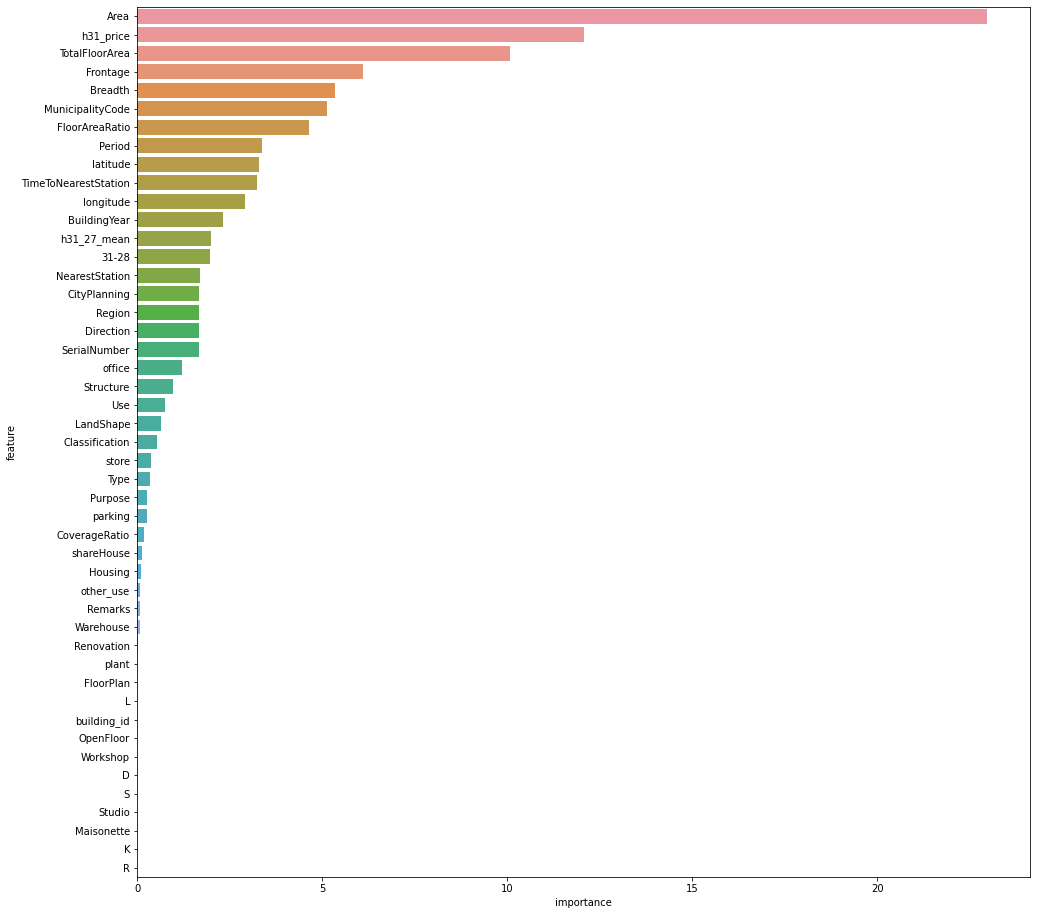

In [14]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.head(70), x='importance', y='feature')

In [17]:
y_pred  = model.predict(test)

In [18]:
y_pred = np.round(y_pred, 2)

In [21]:
submit = pd.read_csv('../data/raw/test_data.csv')

In [24]:
sub = pd.DataFrame({'id': submit['id'], 'y': y_pred})

In [26]:
sub.query('y < 0')

,id,y
325,326,-1.18
331,332,-3.38
333,334,-0.06
496,497,-1.77
580,581,-5.51
...,...,...
34761,34762,-4.79
34769,34770,-7.76
34773,34774,-8.35
34791,34792,-2.79


In [27]:
for i in sub[sub['y'] < 0]['id']:
    sub['y'][i-1] = 0 

In [28]:
sub.to_csv('sub_cat_1.csv', index=False)